In [1]:
import torch
from DPL.RegularizationLoss import RegularizationLoss
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from fl_puf.Utils.tabular_data_loader import get_tabular_numpy_dataset
import os
from DPL.Datasets.dutch import TabularDataset

/home/luca.corbucci/fl_puf/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-22 14:25:28,761	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def compute_violation_with_argmax(
        predictions_argmax: torch.tensor,
        sensitive_attribute_list: torch.tensor,
        current_target: int,
        current_sensitive_feature: int,
    ):
        counter_sensitive_features = Counter(
            [item.item() for item in sensitive_attribute_list]
        )

        opposite_sensitive_feature = 0 if current_sensitive_feature == 1 else 1

        Z_eq_z_argmax = counter_sensitive_features[current_sensitive_feature]
        Z_not_eq_z_argmax = counter_sensitive_features[opposite_sensitive_feature]
        Y_eq_k_and_Z_eq_z_argmax = 0
        Y_eq_k_and_Z_not_eq_z_argmax = 0

        for prediction, sensitive_feature in zip(
            predictions_argmax, sensitive_attribute_list
        ):
            if (
                prediction == current_target
                and sensitive_feature == current_sensitive_feature
            ):
                Y_eq_k_and_Z_eq_z_argmax += 1
            elif (
                prediction == current_target
                and sensitive_feature == opposite_sensitive_feature
            ):
                Y_eq_k_and_Z_not_eq_z_argmax += 1

        if Z_eq_z_argmax == 0 and Z_not_eq_z_argmax != 0:
            return np.abs(Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax).item()
        elif Z_eq_z_argmax != 0 and Z_not_eq_z_argmax == 0:
            return np.abs(Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax).item()
        else:
            # print(
            #     f"Y_eq_k_and_Z_eq_z_argmax: {Y_eq_k_and_Z_eq_z_argmax}, Z_eq_z_argmax: {Z_eq_z_argmax}, Y_eq_k_and_Z_not_eq_z_argmax: {Y_eq_k_and_Z_not_eq_z_argmax}, Z_not_eq_z_argmax: {Z_not_eq_z_argmax}"
            # )
            # print(f"{Y_eq_k_and_Z_eq_z_argmax} / {Z_eq_z_argmax} - {Y_eq_k_and_Z_not_eq_z_argmax} / {Z_not_eq_z_argmax} = {np.abs(Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax - Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax).item()}")
            return  Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax - Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax
            
# plot the bar plot of the disparities
def plot_bar_plot(title: str, disparities: list, nodes: list):
    plt.figure(figsize=(20, 8))
    plt.bar(range(len(disparities)), disparities)
    plt.xticks(range(len(nodes)), nodes)
    plt.title(title)
    # add a vertical line on xtick=75 
    plt.axvline(x=75, color='r', linestyle='--')
    plt.xticks(rotation=90)
    # plt.show()
    # font size x axis 
    plt.rcParams.update({'font.size': 10})
    plt.savefig(f'./{title}.png')
    plt.tight_layout()


def compute_disparities(nodes):
        
    disparities = []
    for node in nodes:
        dataset = torch.load(f'./data/Tabular/adult/federated/{node}/train.pt')
        max_disparity = np.max(
                [
                    RegularizationLoss().compute_violation_with_argmax(
                        predictions_argmax=dataset.targets,
                        sensitive_attribute_list=dataset.sensitive_features,
                        current_target=target,
                        current_sensitive_feature=sv,
                    )
                    for target in range(0, 1)
                    for sv in range(0, 1)
                ]
            )
        disparities.append(max_disparity)
    return disparities

def compute_disparities_per_group(nodes, target, sv, client_data):
    disparities = []
    for client in client_data:
        
        sensive_features = list(client["z"])
        predictions_argmax = list(client["y"])
        disparity = compute_violation_with_argmax(
                            predictions_argmax=predictions_argmax,
                            sensitive_attribute_list=sensive_features,
                            current_target=target,
                            current_sensitive_feature=sv,
                        )

        disparities.append(disparity)
    return disparities

def find_disparity(groups_balance_factor, priv_balance_factor, folder_name=None, do_iid_split=False):
    fed_dir, client_data = prepare_tabular_data(
        dataset_path="./data/Tabular/adult/",
        dataset_name="adult",
        groups_balance_factor=groups_balance_factor,
        priv_balance_factor=priv_balance_factor,
        do_iid_split=do_iid_split,
    )
    clients_disparity, clients_name = get_disparity(client_data)
    # plot the disparity for each client
    print(
        f"Current setup groups_balance_factor={groups_balance_factor}, priv_balance_factor={priv_balance_factor}"
    )
    plt.figure(figsize=(20, 8))
    plt.bar(clients_name, clients_disparity)
    plt.xlabel("Client")
    plt.ylabel("Disparity")
    plt.title("Disparity per client")
    plt.tight_layout()
    if folder_name:
        plt.savefig(
            f"./experiments/{folder_name}/disparity_nodes_{groups_balance_factor}_{priv_balance_factor}.png"
        )
    else:
        plt.show()

    client_dataset_size = []

    for client in client_data:
        client_dataset_size.append(len(client["x"]))
    plot_amount_of_data(client_dataset_size)
    return client_data

def get_disparity(client_data):
    clients_disparity = []
    client_names = []
    for client_name, client in enumerate(client_data):
        max_disparity = 0
        y = list(client["y"])
        z = list(client["z"])
        for target in [0, 1]:
            for sensitive_value in [0, 1]:
                max_disparity = max(
                    RegularizationLoss().compute_violation_with_argmax(
                        predictions_argmax=y,
                        sensitive_attribute_list=z,
                        current_target=target,
                        current_sensitive_feature=sensitive_value,
                    ),
                    max_disparity,
                )
        clients_disparity.append(max_disparity)
        client_names.append(client_name)
    return clients_disparity, client_names

def plot_amount_of_data(client_dataset_size):
    # plot a barplot of the amount of sensitive feature 0 per client and the amount 
    # of sensitive feature 1 per client in the same plot
    plt.figure(figsize=(20, 8))

    plt.bar(range(len(client_dataset_size)), client_dataset_size)


    plt.xlabel("Clients")
    plt.ylabel("Amount of samples")
    plt.title("Amount of samples per client")
    # font size 20
    plt.rcParams.update({'font.size': 20}) 
    plt.tight_layout()
    plt.show()

In [3]:
def prepare_tabular_data(
    dataset_path: str,
    dataset_name: str,
    groups_balance_factor: float,
    priv_balance_factor: float,
    do_iid_split: bool = False,
):
    client_data, N_is, props_positive = get_tabular_data(
        num_clients=150,
        do_iid_split=do_iid_split,
        groups_balance_factor=groups_balance_factor,  # fraction of privileged clients ->
        priv_balance_factor=priv_balance_factor,  # fraction of priv samples the privileged clients should have
        dataset_name="adult",
        num_sensitive_features=1,
        dataset_path=dataset_path,
    )
    # remove the old files in the data folder
    os.system(f"rm -rf {dataset_path}/federated/*")
    for client_name, client in enumerate(client_data):
        # Append 1 to each samples

        custom_dataset = TabularDataset(
            x=np.hstack((client["x"], np.ones((client["x"].shape[0], 1)))).astype(
                np.float32
            ),
            z=client["z"].astype(np.float32),
            y=client["y"].astype(np.float32),
        )
        # Create the folder for the user client_name
        os.system(f"mkdir {dataset_path}/federated/{client_name}")
        # store the dataset in the client folder with the name "train.pt"
        torch.save(
            custom_dataset,
            f"{dataset_path}/federated/{client_name}/train.pt",
        )
    fed_dir = f"{dataset_path}/federated"
    return fed_dir, client_data




def get_tabular_data(
    num_clients: int,
    do_iid_split: bool,
    groups_balance_factor: float,
    priv_balance_factor: float,
    dataset_name: str,
    num_sensitive_features: int,
    dataset_path=None,
):
    X, z, y = get_tabular_numpy_dataset(
        dataset_name=dataset_name,
        num_sensitive_features=num_sensitive_features,
        dataset_path=dataset_path,
    )
    print(f"Data shapes: x={X.shape}, y={y.shape}, z={z.shape}")
    # Prepare training data held by each client
    client_data, N_is, props_positive = generate_clients_biased_data_mod(
        x=X,
        y=y,
        z=z,
        M=num_clients,
        do_iid_split=do_iid_split,
        clients_balance_factor=groups_balance_factor,
        priv_balance_factor=priv_balance_factor,
    )
    return client_data, N_is, props_positive

def compute_violation_with_argmax(
        predictions_argmax: torch.tensor,
        sensitive_attribute_list: torch.tensor,
        current_target: int,
        current_sensitive_feature: int,
    ):
        counter_sensitive_features = Counter(
            [item.item() for item in sensitive_attribute_list]
        )

        opposite_sensitive_feature = 0 if current_sensitive_feature == 1 else 1

        Z_eq_z_argmax = counter_sensitive_features[current_sensitive_feature]
        Z_not_eq_z_argmax = counter_sensitive_features[opposite_sensitive_feature]
        Y_eq_k_and_Z_eq_z_argmax = 0
        Y_eq_k_and_Z_not_eq_z_argmax = 0

        for prediction, sensitive_feature in zip(
            predictions_argmax, sensitive_attribute_list
        ):
            if (
                prediction == current_target
                and sensitive_feature == current_sensitive_feature
            ):
                Y_eq_k_and_Z_eq_z_argmax += 1
            elif (
                prediction == current_target
                and sensitive_feature == opposite_sensitive_feature
            ):
                Y_eq_k_and_Z_not_eq_z_argmax += 1

        if Z_eq_z_argmax == 0 and Z_not_eq_z_argmax != 0:
            return np.abs(Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax).item()
        elif Z_eq_z_argmax != 0 and Z_not_eq_z_argmax == 0:
            return np.abs(Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax).item()
        else:
            print(
                f"Y_eq_k_and_Z_eq_z_argmax: {Y_eq_k_and_Z_eq_z_argmax}, Z_eq_z_argmax: {Z_eq_z_argmax}, Y_eq_k_and_Z_not_eq_z_argmax: {Y_eq_k_and_Z_not_eq_z_argmax}, Z_not_eq_z_argmax: {Z_not_eq_z_argmax}"
            )
            print(f"{Y_eq_k_and_Z_eq_z_argmax} / {Z_eq_z_argmax} - {Y_eq_k_and_Z_not_eq_z_argmax} / {Z_not_eq_z_argmax} = {np.abs(Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax - Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax).item()}")
            return  Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax - Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax
            


In [4]:
# DEBUG 
def compute_disparities_debug(nodes):
    disparities = []
    samples = []
    for node in nodes:
        samples.append(len(node))
        max_disparity = [
                    RegularizationLoss().compute_violation_with_argmax(
                        predictions_argmax=[sample['y'] for sample in node],
                        sensitive_attribute_list=[sample['z'] for sample in node],
                        current_target=target,
                        current_sensitive_feature=sv,
                    )
                    for target in [0, 1]
                    for sv in [0, 1]
                ]
        disparities.append(np.max(max_disparity))
    print(f"Mean of disparity {np.mean(disparities)} - std {np.std(disparities)} - Mean number o samples {np.mean(samples)}")
    return disparities


def compute_disparities_per_group_debug(nodes, target, sv, client_data):
    disparities = []
    for client in client_data:
        
        sensive_features = [sample["z"] for sample in client]
        predictions_argmax = [sample["y"] for sample in client]
        disparity = compute_violation_with_argmax(
                            predictions_argmax=predictions_argmax,
                            sensitive_attribute_list=sensive_features,
                            current_target=target,
                            current_sensitive_feature=sv,
                        )

        disparities.append(disparity)
    return disparities

In [5]:
# egalitarian point of view: equal representation of each subgroup 100 samples->25 per group
# representative diversity: each node has the same ratio that we are observing in the dataset 

# representative diversity + unfair nodes that exagerates the disparity
# (ratio_fair_nodes, ratio_unfair_nodes, number_of_samples_per_node)

# one more parameter: how many fair ndoes want to have more 0 or more 1s. -> expeirments with nodes that go in one direction and nodes
# that go to other direction
# another parameter -> egalitarian vs representative diversity

# Othre idea: solve the problem of opposite directons with an alternative to DPL.

def egalitarian_approach(X, y, z, num_nodes, number_of_samples_per_node=None):
    """
    With this approach we want to distribute the data among the nodes in an egalitarian way.
    This means that each node has the same amount of data and the same ratio of each group

    params:
    X: numpy array of shape (N, D) where N is the number of samples and D is the number of features
    y: numpy array of shape (N, ) where N is the number of samples. Here we have the samples labels
    z: numpy array of shape (N, ) where N is the number of samples. Here we have the samples sensitive features
    num_nodes: number of nodes to generate
    number_of_samples_per_node: number of samples that we want in each node. Can be None, in this case we just use 
        len(y)//num_nodes
    """
    combinations = [(target, sensitive_value) for target, sensitive_value in zip(y, z)]
    possible_combinations = set(combinations)
    data = {}
    for combination, x_, y_, z_ in zip(combinations, X, y, z):
        if combination not in data:
            data[combination] = []
        data[combination].append({"x": x_, "y": y_, "z": z_})

    samples_from_each_group = min(list(Counter(combinations).values())) // num_nodes

    if number_of_samples_per_node:
        assert samples_from_each_group*len(possible_combinations) >= number_of_samples_per_node, "Too many samples per node, choose a different number of samples per node"
        if samples_from_each_group*len(possible_combinations) >= number_of_samples_per_node:
            to_be_removed = (samples_from_each_group*len(possible_combinations) - number_of_samples_per_node)//len(possible_combinations)
            samples_from_each_group -= to_be_removed
            

    # create the nodes
    nodes = []
    for i in range(num_nodes):
        nodes.append([])
        # fill the nodes
        for combination in data:
            nodes[i].extend(data[combination][:samples_from_each_group])
            data[combination] = data[combination][samples_from_each_group:]

    
    return nodes, data

def create_unfair_nodes(fair_nodes: list, nodes_to_unfair: list, remaining_data: dict, group_to_reduce: tuple, group_to_increment:tuple, ratio_unfairness: tuple):
    """
    This function creates the unfair nodes. It takes the nodes that we want to be unfair and the remaining data
    and it returns the unfair nodes created by reducing the group_to_reduce and incrementing the group_to_increment
    based on the ratio_unfairness

    params:
    nodes_to_unfair: list of nodes that we want to make unfair
    remaining_data: dictionary with the remaining data that we will use to replace the 
        samples that we remove from the nodes_to_unfair
    group_to_reduce: the group that we want to be unfair. For instance, in the case of binary target and binary sensitive value
        we could have (0,0), (0,1), (1,0) or (1,1)
    group_to_increment: the group that we want to increment. For instance, in the case of binary target and binary sensitive value
        we could have (0,0), (0,1), (1,0) or (1,1)
    ratio_unfairness: tuple (min, max) where min is the minimum ratio of samples that we want to remove from the group_to_reduce
    """
    #assert remaining_data[group_to_reduce] != [], "Choose a different group to be unfair"
    # remove the samples from the group that we want to be unfair
    unfair_nodes = []
    number_of_samples_to_add = []
    removed_samples = []

    for node in nodes_to_unfair:
        node_data = []
        count_sensitive_group_samples = 0
        # We count how many sample each node has from the group that we want to reduce
        for sample in node:
            if (sample['y'], sample["z"]) == group_to_reduce:
                count_sensitive_group_samples += 1

        # We compute the number of samples that we want to remove from the group_to_reduce
        # based on the ratio_unfairness
        current_ratio = np.random.uniform(ratio_unfairness[0], ratio_unfairness[1])
        samples_to_be_removed = int(count_sensitive_group_samples*current_ratio)
        number_of_samples_to_add.append(samples_to_be_removed)

        for sample in node:
            # Now we remove the samples from the group_to_reduce 
            # and we store them in removed_samples
            if (sample['y'], sample["z"]) == group_to_reduce and samples_to_be_removed > 0:
                samples_to_be_removed -= 1
                removed_samples.append(sample)
            else:
                node_data.append(sample)
        unfair_nodes.append(node_data)

    # Now we have to distribute the removed samples among the fair nodes
    max_samples_to_add = len(removed_samples)//len(fair_nodes)
    for node in fair_nodes:
        node.extend(removed_samples[:max_samples_to_add])
        removed_samples = removed_samples[max_samples_to_add:]
    
    
    if group_to_increment:
        # Now we have to remove the samples from the group_to_increment
        # from the fair_nodes based on the number_of_samples_to_add
        for node in fair_nodes:
            samples_to_remove = sum(number_of_samples_to_add) // len(fair_nodes)
            for index, sample in enumerate(node):
                if (sample['y'], sample["z"]) == group_to_increment and samples_to_remove > 0:
                    if (sample['y'], sample["z"]) not in remaining_data:
                        remaining_data[group_to_increment] = []
                    remaining_data[group_to_increment].append(sample)
                    samples_to_remove -= 1
                    node.pop(index)
            if sum(number_of_samples_to_add) > 0:
                assert samples_to_remove == 0, "Not enough samples to remove"
        assert sum(number_of_samples_to_add) <= len(remaining_data[group_to_increment]), "Too many samples to add"
        # now we have to add the same amount of data taken from group_to_unfair
        for node, samples_to_add in zip(unfair_nodes, number_of_samples_to_add):
            node.extend(remaining_data[group_to_increment][:samples_to_add])
            remaining_data[group_to_increment] = remaining_data[group_to_increment][samples_to_add:]

    return fair_nodes, unfair_nodes

def representative_diversity_approach(X, y, z, num_nodes, number_of_samples_per_node):
    """
    With this approach we want to distribute the data among the nodes in a representative diversity way.
    This means that each node has the same ratio of each group that we are observing in the dataset

    params:
    X: numpy array of shape (N, D) where N is the number of samples and D is the number of features
    y: numpy array of shape (N, ) where N is the number of samples. Here we have the samples labels
    z: numpy array of shape (N, ) where N is the number of samples. Here we have the samples sensitive features
    num_nodes: number of nodes to generate
    number_of_samples_per_node: number of samples that we want in each node. Can be None, in this case we just use
        len(y)//num_nodes
    """
    samples_per_node = number_of_samples_per_node if number_of_samples_per_node else len(y)//num_nodes
    # create the nodes sampling from the dataset wihout replacement
    dataset = [{"x": x_, "y": y_, "z": z_} for x_, y_, z_ in zip(X, y, z)]
    # shuffle the dataset
    np.random.shuffle(dataset)

    # Distribute the data among the nodes with a random sample from the dataset 
    # considering the number of samples per node
    nodes = []
    for i in range(num_nodes):
        nodes.append([])
        nodes[i].extend(dataset[:samples_per_node])
        dataset = dataset[samples_per_node:]
    
    remaining_data = {}
    
    if number_of_samples_per_node:
        # Create the dictionary with the remaining data
        for sample in dataset:
            if (sample['y'], sample['z']) not in remaining_data:
                remaining_data[(sample['y'], sample['z'])] = []
            remaining_data[(sample['y'], sample['z'])].append(sample)

    return nodes, remaining_data

def generate_clients_biased_data_mod(
    x, 
    y, 
    z, 
    approach:str, 
    num_nodes:int, 
    ratio_unfair_nodes:float, 
    opposite_direction:bool, 
    ratio_unfairness:tuple, 
    group_to_reduce:tuple=None, 
    group_to_increment:tuple=None, 
    number_of_samples_per_node:int=None, 
    opposite_group_to_reduce:tuple=None,
    opposite_group_to_increment:tuple=None,
    opposite_ratio_unfairness:tuple=None,):
    """
    This function generates the data for the clients.

    params:
    X: numpy array of shape (N, D) where N is the number of samples and D is the number of features
    y: numpy array of shape (N, ) where N is the number of samples. Here we have the samples labels
    z: numpy array of shape (N, ) where N is the number of samples. Here we have the samples sensitive features
    num_nodes: number of nodes to generate
    approach: type of approach we want to use to distribute the data among the fair clients. This can be egalitarian or representative
    ratio_unfair_nodes: the fraction of unfair clients we want to have in the experiment 
    opposite_direction: true if we want to allow different nodes to have different majoritiarian classes. For instance, 
        we could have some nodes with a max disparity that depends on the majority class being 0 and other nodes with a max disparity
        that depends on the majority class being 1.
    group_to_reduce: the group that we want to be unfair. For instance, in the case of binary target and binary sensitive value 
        we could have (0,0), (0,1), (1,0) or (1,1)
    ratio_unfairness: tuple (min, max) where min is the minimum ratio of samples that we want to remove from the group_to_reduce
        and max is the maximum ratio of samples that we want to remove from the group_to_reduce
    """

    # check if the number of samples that we want in each node is
    # greater than the number of samples we have in the dataset
    if number_of_samples_per_node:
        assert number_of_samples_per_node < len(y)//num_nodes, "Too many samples per node"
    # check if the ratio_fair_nodes is between 0 and 1
    assert ratio_unfair_nodes <= 1, "ratio_unfair_nodes must be less or equal than 1"
    assert ratio_unfair_nodes >= 0, "ratio_unfair_nodes must be greater or equal than 0"
    assert group_to_reduce != None, "group_to_reduce must be specified"
    # assert group_to_increment != None, "group_to_increment must be specified"
    # check if the approach type is egalitarian or representative
    assert approach in ["egalitarian", "representative"], "Approach must be egalitarian or representative"

    number_unfair_nodes = int(num_nodes*ratio_unfair_nodes)
    number_fair_nodes = num_nodes - number_unfair_nodes
    if approach == "egalitarian":
        # first split the data among the nodes in an egalitarian way
        # each node has the same amount of data and the same ratio of each group
        nodes, remaining_data = egalitarian_approach(X, y, z, num_nodes, number_of_samples_per_node)
    else:
        nodes, remaining_data = representative_diversity_approach(X, y, z, num_nodes, number_of_samples_per_node)

    if opposite_direction:
        assert opposite_group_to_reduce != None, "opposite_group_to_reduce must be specified"
        assert opposite_group_to_increment != None, "opposite_group_to_increment must be specified"
        group_size = number_unfair_nodes//2
        unfair_nodes_direction_1 = create_unfair_nodes(nodes_to_unfair=nodes[number_unfair_nodes:number_unfair_nodes+group_size], remaining_data=remaining_data, group_to_reduce=group_to_reduce, group_to_increment=group_to_increment, ratio_unfairness=ratio_unfairness)
        unfair_nodes_direction_2 = create_unfair_nodes(nodes_to_unfair=nodes[number_unfair_nodes+group_size:], remaining_data=remaining_data, group_to_reduce=opposite_group_to_reduce, group_to_increment=opposite_group_to_increment, ratio_unfairness=opposite_ratio_unfairness)
        return nodes[0:number_unfair_nodes] + unfair_nodes_direction_1 + unfair_nodes_direction_2
    else:
        fair_nodes, unfair_nodes = create_unfair_nodes(fair_nodes=nodes[0:number_fair_nodes], nodes_to_unfair=nodes[number_fair_nodes:], remaining_data=remaining_data, group_to_reduce=group_to_reduce, group_to_increment=group_to_increment, ratio_unfairness=ratio_unfairness)
        return fair_nodes + unfair_nodes

In [6]:
X, z, y = get_tabular_numpy_dataset(
        dataset_name="adult",
        num_sensitive_features=1,
        dataset_path=f"./data/Tabular/adult/",
    )
z = z[:, 0]
print(X.shape)

# X, z, y = get_tabular_numpy_dataset(
#         dataset_name="dutch",
#         num_sensitive_features=1,
#         dataset_path=f"./data/Tabular/dutch/",
#     )
# z = z[:, 0]
# print(X.shape)

Using ['sex_binary'] as sensitive feature(s).
(48842, 110)


In [7]:
y = y.astype(np.int64)

In [8]:
combinations = []
for target, sv in zip(y, z):
    combinations.append((target.item(), sv.item()))

print(Counter(combinations))

Counter({(0, 0): 25988, (0, 1): 15013, (1, 0): 6662, (1, 1): 1179})


In [9]:
# X, z, y = get_tabular_numpy_dataset(
#         dataset_name="adult",
#         num_sensitive_features=1,
#         dataset_path=f"./data/Tabular/adult/",
#     )
# z = z[:, 0]
# y = [int(item) for item in y]

# Adult

In [52]:
import random 
random.seed(42)

Mean of disparity 0.13091633012324083 - std 0.0250606114222982 - Mean number o samples 650.0


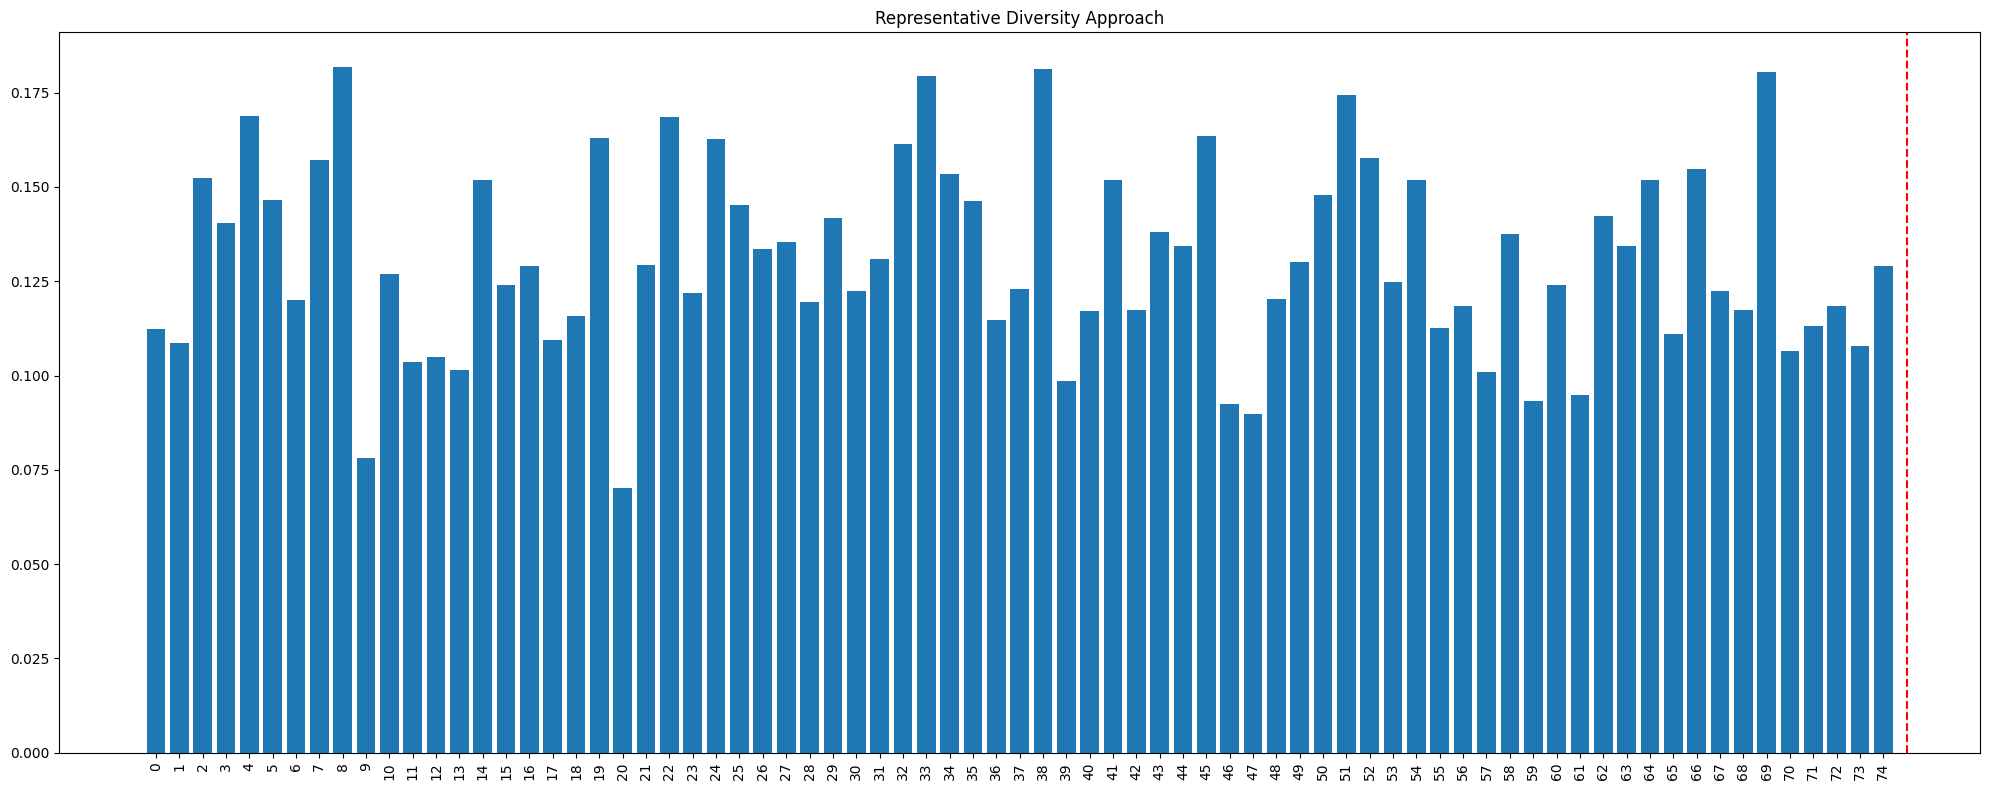

In [114]:
nodes = generate_clients_biased_data_mod(X, y, z, approach="representative", num_nodes=75, ratio_unfair_nodes=0.3, opposite_direction=False, ratio_unfairness=(0, 0), group_to_reduce=(1,0), group_to_increment=(0,0), number_of_samples_per_node=650)
disparities = compute_disparities_debug(nodes)
# plot the bar plot of the disparities
plot_bar_plot(title="Representative Diversity Approach", disparities=disparities, nodes=[f"{i}" for i in range(len(nodes))])

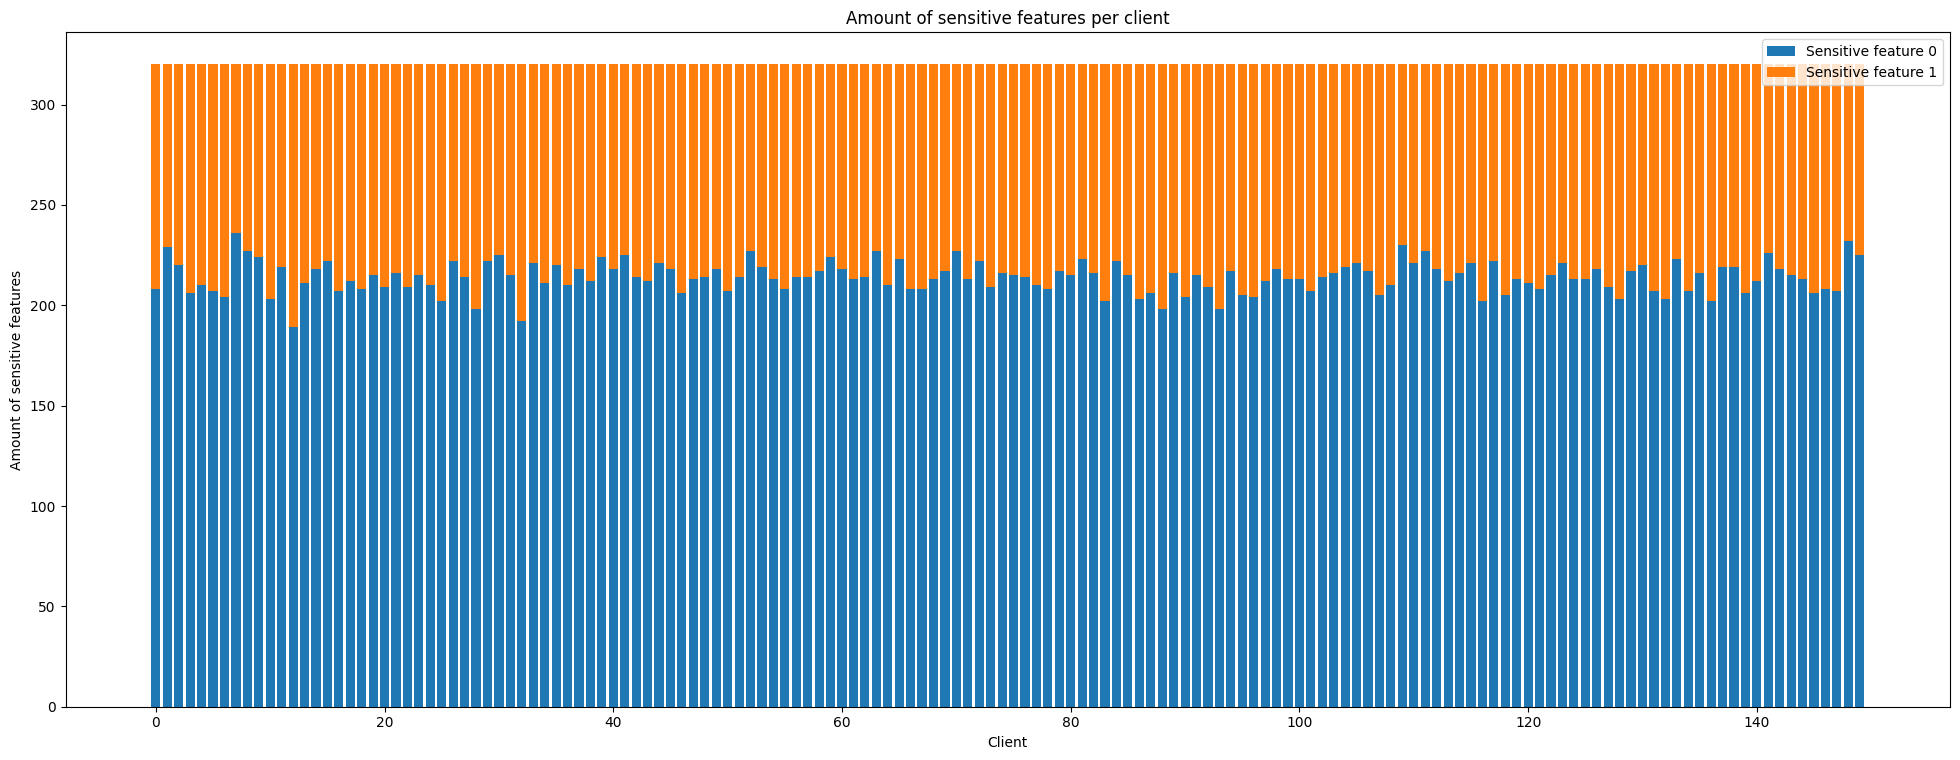

In [111]:
clients_targets = []
clients_sensitive_values = []
clients_target_sensitive = []
client_dataset_size = []

# transform client data so that they are compatiblw with the
# other functions
tmp_data = []
for client in nodes:
    tmp_x = []
    tmp_y = []
    tmp_z = []
    for sample in client:
        tmp_x.append(sample["x"])
        tmp_y.append(sample["y"])
        tmp_z.append(sample["z"])
    tmp_data.append(
        {"x": np.array(tmp_x), "y": np.array(tmp_y), "z": np.array(tmp_z)}
    )
client_data = tmp_data

for client in client_data:
    clients_targets.append(list(client["y"]))
    clients_sensitive_values.append(list(client["z"]))
    client_dataset_size.append(len(client["x"]))
    tmp = []
    for target, sensitive_value in zip(list(client["y"]), list(client["z"])):
        tmp.append((target, sensitive_value))   
    clients_target_sensitive.append(tmp)

counter_sensitive_features = [Counter(sensive_features) for sensive_features in clients_sensitive_values]

counter_sensitive_features_0 = [counter[0.0] for counter in counter_sensitive_features]
counter_sensitive_features_1 = [counter[1.0] for counter in counter_sensitive_features]

 # plot a barplot of the amount of sensitive feature 0 per client and the amount 
 # of sensitive feature 1 per client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_sensitive_features_0)), counter_sensitive_features_0)

plt.bar(range(len(counter_sensitive_features_1)), counter_sensitive_features_1, bottom=counter_sensitive_features_0)

plt.xlabel("Client")
plt.ylabel("Amount of sensitive features")
plt.title("Amount of sensitive features per client")
plt.legend(["Sensitive feature 0", "Sensitive feature 1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

Counter({(0, 0): 156, (0, 1): 97, (1, 0): 52, (1, 1): 15})
Counter({(0, 0): 182, (0, 1): 88, (1, 0): 43, (1, 1): 7})


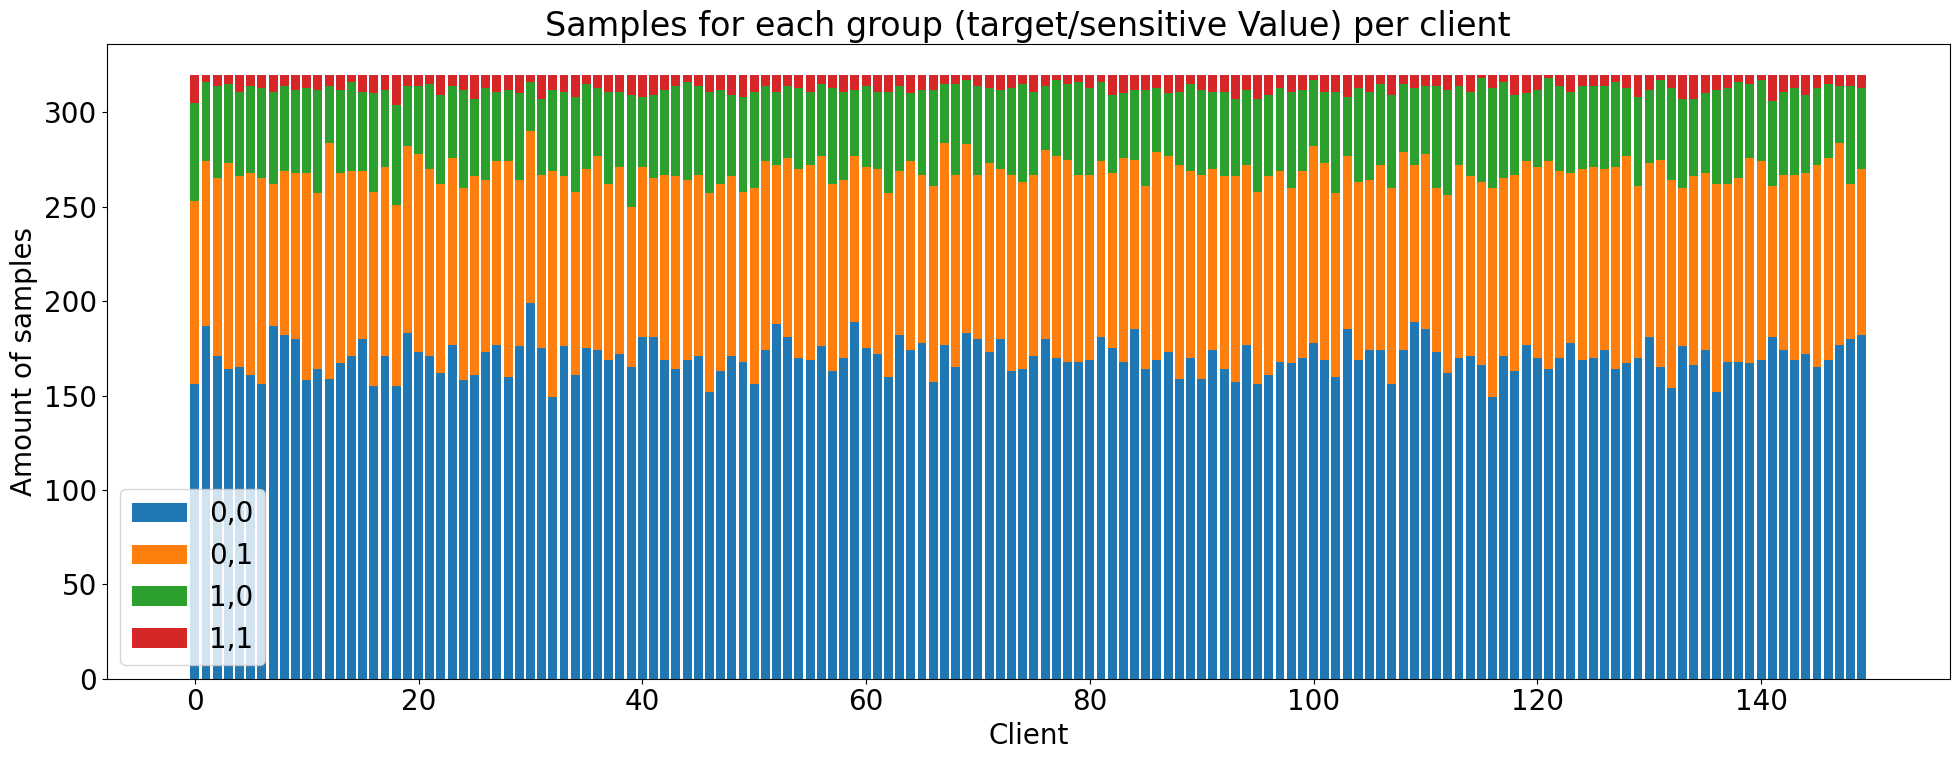

In [112]:

counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]
print(counter_groups[0])
print(counter_groups[-1])
counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

 # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
 # for each client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])



plt.xlabel("Client")
plt.ylabel("Amount of samples")
plt.title("Samples for each group (target/sensitive Value) per client")
plt.legend(["0,0", "0,1", "1,0", "1,1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

#group_to_reduce=(0,1), group_to_increment=(1,1),
# 0, 0 -> 1, 0

# Dutch

Mean of disparity 0.2948349889419153 - std 0.16844094475505478 - Mean number o samples 343.0


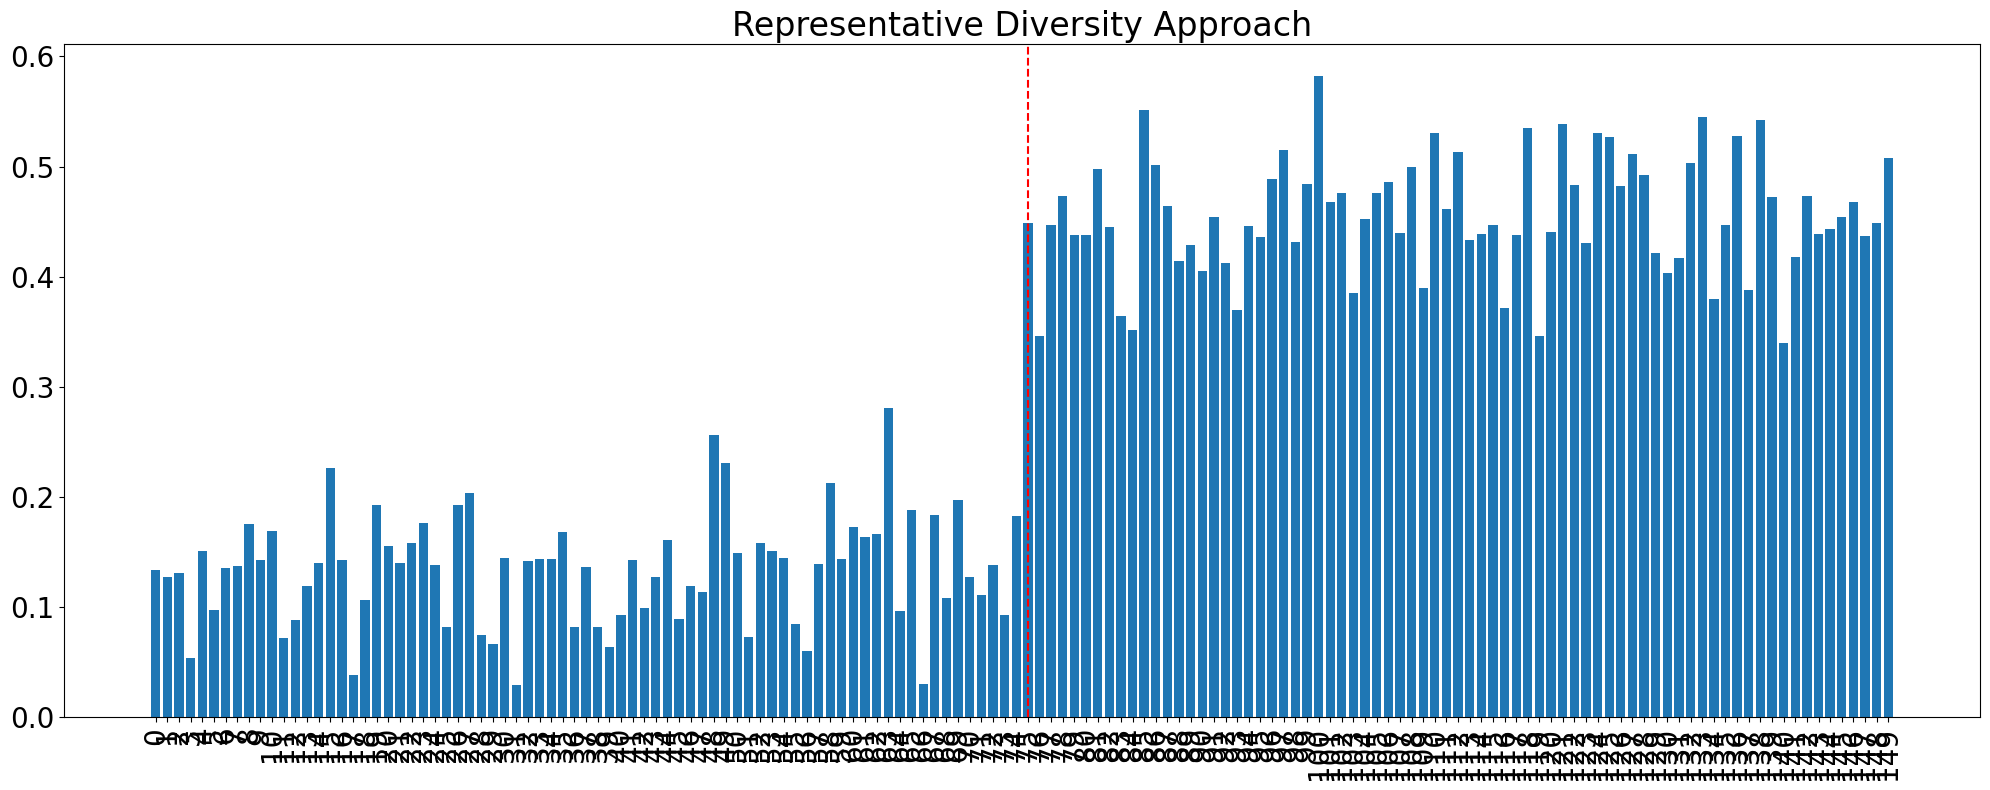

In [264]:
nodes = generate_clients_biased_data_mod(X, y, z, approach="representative", num_nodes=150, ratio_unfair_nodes=0.5, opposite_direction=False, ratio_unfairness=(0.4, 0.6), group_to_reduce=(0,1), group_to_increment=(1,1), number_of_samples_per_node=343)
disparities = compute_disparities_debug(nodes)
# plot the bar plot of the disparities
plot_bar_plot(title="Representative Diversity Approach", disparities=disparities, nodes=[f"{i}" for i in range(len(nodes))])

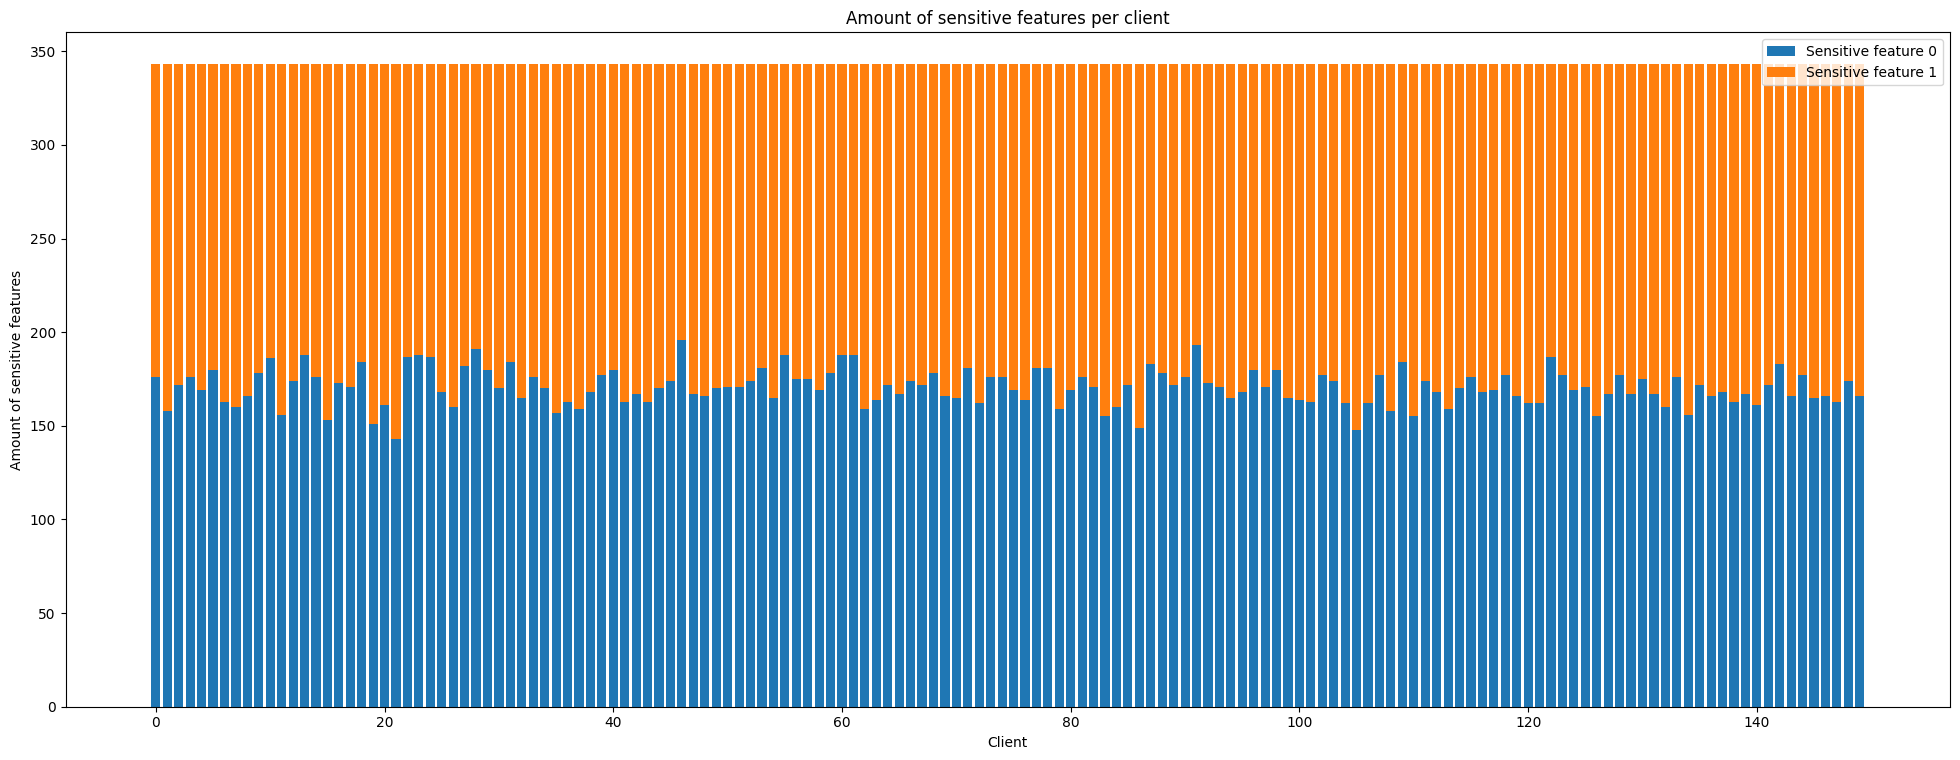

In [265]:
clients_targets = []
clients_sensitive_values = []
clients_target_sensitive = []
client_dataset_size = []

# transform client data so that they are compatiblw with the
# other functions
tmp_data = []
for client in nodes:
    tmp_x = []
    tmp_y = []
    tmp_z = []
    for sample in client:
        tmp_x.append(sample["x"])
        tmp_y.append(sample["y"])
        tmp_z.append(sample["z"])
    tmp_data.append(
        {"x": np.array(tmp_x), "y": np.array(tmp_y), "z": np.array(tmp_z)}
    )
client_data = tmp_data

for client in client_data:
    clients_targets.append(list(client["y"]))
    clients_sensitive_values.append(list(client["z"]))
    client_dataset_size.append(len(client["x"]))
    tmp = []
    for target, sensitive_value in zip(list(client["y"]), list(client["z"])):
        tmp.append((target, sensitive_value))   
    clients_target_sensitive.append(tmp)

counter_sensitive_features = [Counter(sensive_features) for sensive_features in clients_sensitive_values]

counter_sensitive_features_0 = [counter[0.0] for counter in counter_sensitive_features]
counter_sensitive_features_1 = [counter[1.0] for counter in counter_sensitive_features]

 # plot a barplot of the amount of sensitive feature 0 per client and the amount 
 # of sensitive feature 1 per client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_sensitive_features_0)), counter_sensitive_features_0)

plt.bar(range(len(counter_sensitive_features_1)), counter_sensitive_features_1, bottom=counter_sensitive_features_0)

plt.xlabel("Client")
plt.ylabel("Amount of sensitive features")
plt.title("Amount of sensitive features per client")
plt.legend(["Sensitive feature 0", "Sensitive feature 1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()


Counter({(0, 0): 111, (1, 1): 84, (0, 1): 83, (1, 0): 65})
Counter({(1, 1): 156, (0, 0): 104, (1, 0): 62, (0, 1): 21})


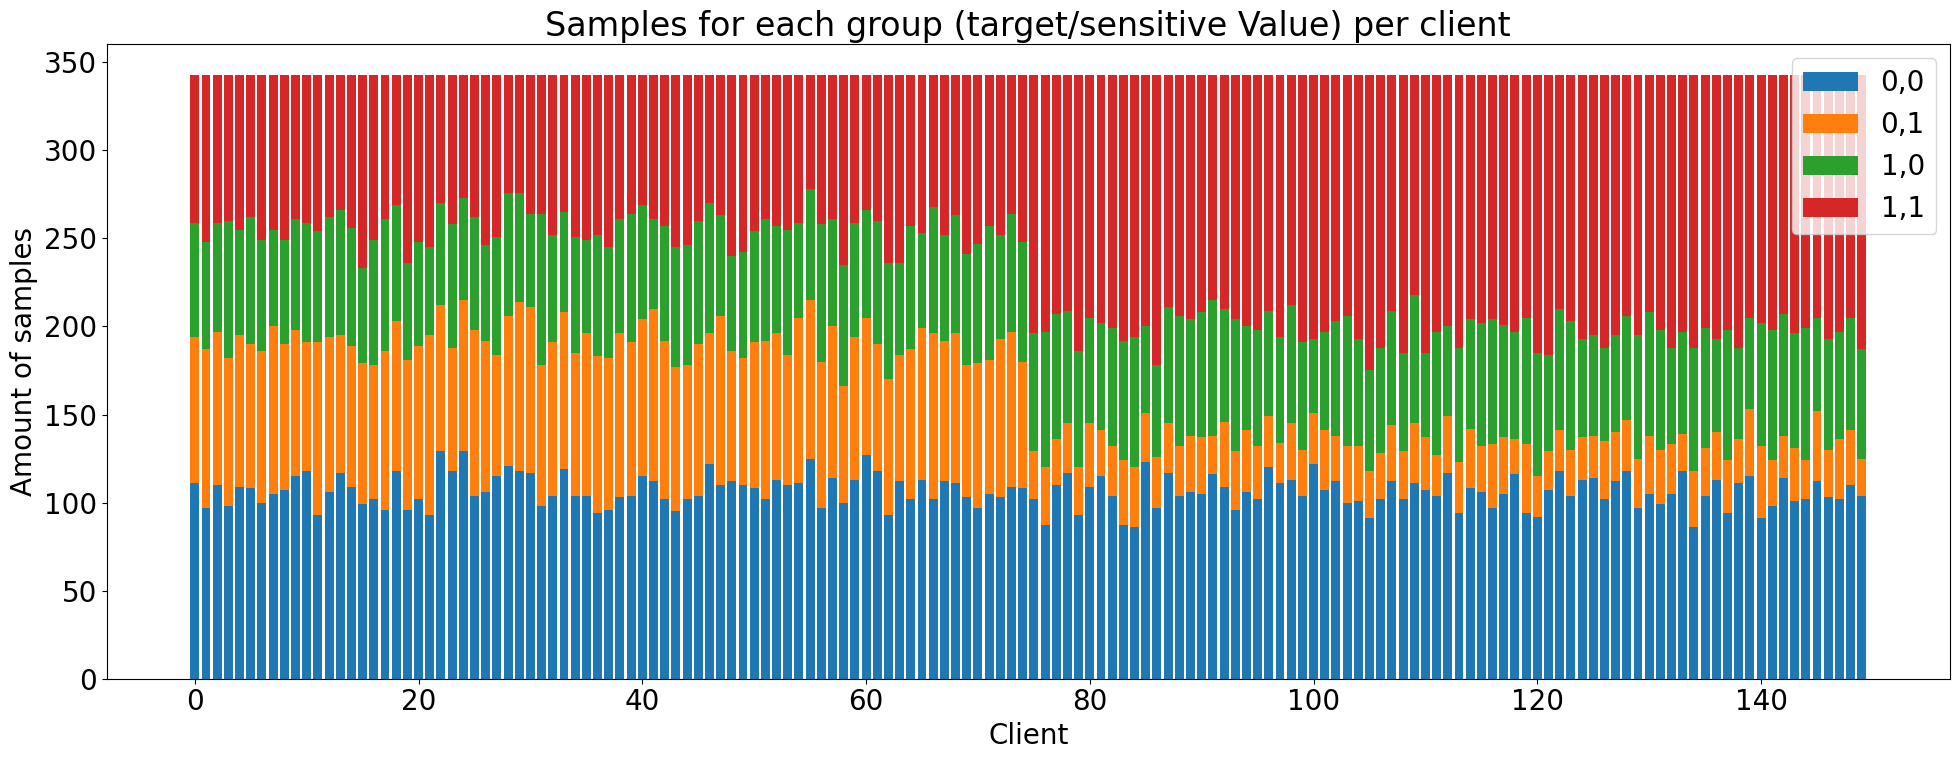

In [266]:

counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]
print(counter_groups[0])
print(counter_groups[-1])
counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

 # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
 # for each client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])



plt.xlabel("Client")
plt.ylabel("Amount of samples")
plt.title("Samples for each group (target/sensitive Value) per client")
plt.legend(["0,0", "0,1", "1,0", "1,1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

#group_to_reduce=(0,1), group_to_increment=(1,1),
# 0, 0 -> 1, 0

# Opposite

In [ ]:
nodes = generate_clients_biased_data_mod(X, y, z, approach="representative", num_nodes=150, ratio_unfair_nodes=0.5, opposite_direction=True, ratio_unfairness=(0.7, 0.8), group_to_reduce=(0,1), group_to_increment=(1,1), number_of_samples_per_node=300, opposite_group_to_reduce=(0,0), opposite_group_to_increment=(1,0), opposite_ratio_unfairness=(0.6, 0.8))
disparities = compute_disparities_debug(nodes)
# plot the bar plot of the disparities
plot_bar_plot(title="Opposite Approach", disparities=disparities, nodes=[f"{i}" for i in range(len(nodes))])


In [ ]:
disparities_0_0 = compute_disparities_per_group_debug(list(range(0,150)), target=0, sv=0, client_data=nodes)
disparities_1_0 = compute_disparities_per_group_debug(list(range(0,150)), target=1, sv=0, client_data=nodes)
disparities_0_1 = compute_disparities_per_group_debug(list(range(0,150)), target=0, sv=1, client_data=nodes)
disparities_1_1 = compute_disparities_per_group_debug(list(range(0,150)), target=1, sv=1, client_data=nodes)
plot_bar_plot(title="Nodes disparity Y=0, Z=1: P(Y=0|Z=0) - P(Y=0|Z=1)", disparities=disparities_0_1, nodes=list(range(0,150)))
plot_bar_plot(title="Nodes disparity Y=1, Z=0: P(Y=1|Z=0) - P(Y=1|Z=1)", disparities=disparities_1_0, nodes=list(range(0,150)))
plot_bar_plot(title="Nodes disparity Y=1, Z=1: P(Y=1|Z=1) - P(Y=1|Z=0)", disparities=disparities_1_1, nodes=list(range(0,150)))
plot_bar_plot(title="Nodes disparity Y=0, Z=0: P(Y=0|Z=0) - P(Y=0|Z=1)", disparities=disparities_0_0, nodes=list(range(0,150)))

In [ ]:
# counter_groups = [Counter([(sample['y'], sample['z']) for sample in node]) for node in nodes]
# # # counter_groups =[Counter(client_data) for client_data in clients_target_sensitive]

# # counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
# # counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
# # counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
# # counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

# #  # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
# #  # for each client in the same plot
# # plt.figure(figsize=(20, 8))

# # plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
# # plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
# # plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
# # plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])


# # plt.xlabel("Client")
# # plt.ylabel("Amount of samples")
# # plt.title("Samples for each group (target/sensitive Value) per client")
# # plt.legend(["0,0", "0,1", "1,0", "1,1"])
# # # font size 20
# # plt.rcParams.update({'font.size': 20}) 
# # plt.tight_layout()

In [ ]:
sum([len(node) for node in nodes])

# Egalitarian

Mean of disparity 0.0 - std 0.0


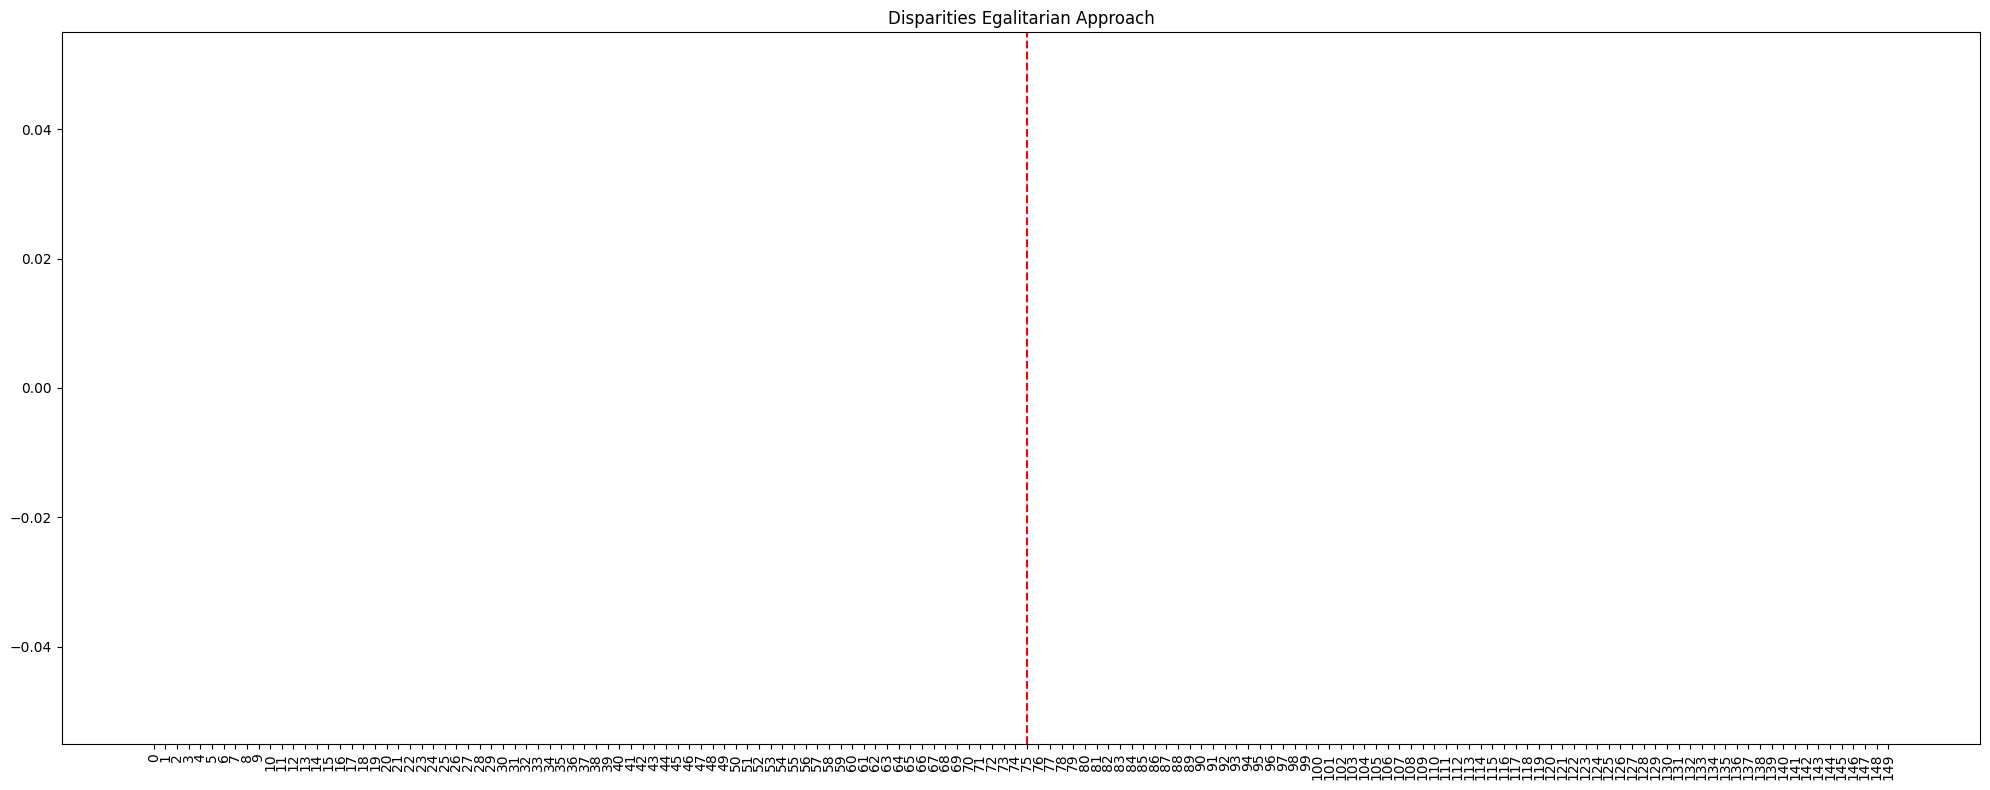

In [38]:
nodes = generate_clients_biased_data_mod(X, y, z, approach="egalitarian", num_nodes=150, ratio_unfair_nodes=0.5, opposite_direction=False, ratio_unfairness=(0.3, 0.6), group_to_reduce=(0,1), group_to_increment=(1,1))
disparities = compute_disparities_debug(nodes)
# plot the bar plot of the disparities
plot_bar_plot(title="Disparities Egalitarian Approach", disparities=disparities, nodes=[f"{i}" for i in range(len(nodes))])

In [ ]:
combinations = [(target, sensitive_value) for target, sensitive_value in zip(y, z)]

In [ ]:
Counter(combinations)

In [ ]:
print("Disparity 0, 0: ", compute_violation_with_argmax(y, z, 0, 0))
print("Disparity 0, 1: ", compute_violation_with_argmax(y, z, 0, 1))
print("Disparity 1, 0: ", compute_violation_with_argmax(y, z, 1, 0))
print("Disparity 1, 1: ", compute_violation_with_argmax(y, z, 1, 1))

In [ ]:
len(X)
# two groups: fair nodes and unfair nodes
# to create the fair nodes 

In [ ]:
all_nodes = list(range(0, 150))

In [ ]:
# # range from 0.1 to 0.9 step is 0.1

# for groups_balance_factor in np.arange(0.1, 0.9, 0.1):
#     for priv_balance_factor in np.arange(0.5, 0.9, 0.1):
#         client_data = find_disparity(
#                     groups_balance_factor=groups_balance_factor, priv_balance_factor=priv_balance_factor
#                 ) 

In [ ]:
client_data = find_disparity(
            groups_balance_factor=0.5, priv_balance_factor=0.8
        )

In [ ]:
clients_targets = []
clients_sensitive_values = []
clients_target_sensitive = []
client_dataset_size = []

for client in client_data:
    clients_targets.append(list(client["y"]))
    clients_sensitive_values.append(list(client["z"]))
    client_dataset_size.append(len(client["x"]))
    tmp = []
    for target, sensitive_value in zip(list(client["y"]), list(client["z"])):
        tmp.append((target, sensitive_value))   
    clients_target_sensitive.append(tmp)

counter_sensitive_features = [Counter(sensive_features) for sensive_features in clients_sensitive_values]

counter_sensitive_features_0 = [counter[0.0] for counter in counter_sensitive_features]
counter_sensitive_features_1 = [counter[1.0] for counter in counter_sensitive_features]

In [ ]:
counter_sensitive_features = [Counter(sensive_features) for sensive_features in clients_sensitive_values]

counter_sensitive_features_0 = [counter[0.0] for counter in counter_sensitive_features]
counter_sensitive_features_1 = [counter[1.0] for counter in counter_sensitive_features]

In [ ]:
 # plot a barplot of the amount of sensitive feature 0 per client and the amount 
 # of sensitive feature 1 per client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_sensitive_features_0)), counter_sensitive_features_0)

plt.bar(range(len(counter_sensitive_features_1)), counter_sensitive_features_1, bottom=counter_sensitive_features_0)

plt.xlabel("Client")
plt.ylabel("Amount of sensitive features")
plt.title("Amount of sensitive features per client")
plt.legend(["Sensitive feature 0", "Sensitive feature 1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

In [ ]:
counter_sensitive_features_0[0]

In [ ]:
counter_sensitive_features_1[0]

In [ ]:
counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]

counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

In [ ]:

counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]

counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

 # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
 # for each client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])


plt.xlabel("Client")
plt.ylabel("Amount of samples")
plt.title("Samples for each group (target/sensitive Value) per client")
plt.legend(["0,0", "0,1", "1,0", "1,1"])
# font size 20
plt.rcParams.update({'font.size': 20}) 
plt.tight_layout()

In [ ]:
# egalitarian point of view: equal representation of each subgroup 100 samples->25 per group
# representative diversity: each node has the same ratio that we are observing in the dataset 

# representative diversity + unfair nodes that exagerates the disparity
# (ratio_fair_nodes, ratio_unfair_nodes, number_of_samples_per_node)

# one more parameter: how many fair ndoes want to have more 0 or more 1s. -> expeirments with nodes that go in one direction and nodes
# that go to other direction
# another parameter -> egalitarian vs representative diversity

# Othre idea: solve the problem of opposite directons with an alternative to DPL.

In [ ]:
print(counter_group_0_0[0], counter_group_0_1[0], counter_group_1_0[0], counter_group_1_1[0])

In [ ]:
disparities_0_0 = compute_disparities_per_group(all_nodes, target=0, sv=0, client_data=client_data)
disparities_1_0 = compute_disparities_per_group(all_nodes, target=1, sv=0, client_data=client_data)
disparities_0_1 = compute_disparities_per_group(all_nodes, target=0, sv=1, client_data=client_data)
disparities_1_1 = compute_disparities_per_group(all_nodes, target=1, sv=1, client_data=client_data)

In [ ]:
plot_bar_plot(title="Nodes disparity Y=0, Z=0", disparities=disparities_0_1, nodes=all_nodes)

In [ ]:
plot_bar_plot(title="Nodes disparity Y=1, Z=0", disparities=disparities_1_0, nodes=all_nodes)

In [ ]:
plot_bar_plot(title="Nodes disparity Y=1, Z=1", disparities=disparities_1_1, nodes=all_nodes)

In [ ]:
plot_bar_plot(title="Nodes disparity Y=0, Z=0", disparities=disparities_0_0, nodes=all_nodes)

In [ ]:
possible_combinations = [(1.0), (0.0)]

In [ ]:
combinations = []
for node in all_nodes:
    dataset = torch.load(f'./data/Tabular/adult/federated/{node}/train.pt')
    tmp = []
    for target, sv in zip(dataset.targets, dataset.gender):
        tmp.append((sv))
    combinations.append(Counter(tmp))

# for node_name, node in zip(all_nodes, combinations):
#     print(f"Node {node_name}", node)

In [ ]:
for possible_combination in possible_combinations:
    counter_ = []
    for combination in combinations:
        counter_.append(combination[possible_combination])
    # plot the amount of samples per node for each combination
    # using a bar plot
    plt.figure(figsize=(25, 5))
    
    plt.bar(all_nodes, counter_, label=f"{possible_combination}")
    plt.legend()
    plt.xlabel("Node")
    plt.ylabel("Amount of samples")
    plt.title("Amount of samples per node for each combination")
    plt.show()

In [ ]:
all_disparities = compute_disparities(all_nodes)
plot_bar_plot(title="All nodes disparity", disparities=all_disparities, nodes=all_nodes)

In [ ]:
disparities_0_0 = compute_disparities_per_group(all_nodes, target=0, sv=0)
disparities_1_0 = compute_disparities_per_group(all_nodes, target=1, sv=0)
disparities_0_1 = compute_disparities_per_group(all_nodes, target=0, sv=1)
disparities_1_1 = compute_disparities_per_group(all_nodes, target=1, sv=1)

In [ ]:
plot_bar_plot(title="Nodes disparity Y=0, Z=0", disparities=disparities_0_0, nodes=all_nodes)

In [ ]:
plot_bar_plot(title="Nodes disparity Y=1, Z=1", disparities=disparities_1_1, nodes=all_nodes)

In [ ]:
plot_bar_plot(title="Train nodes disparity", disparities=disparities_0_0, nodes=training_nodes)

In [ ]:
plot_bar_plot(title="Train nodes disparity", disparities=disparities_1_0, nodes=training_nodes)

In [ ]:
validation_disparities = compute_disparities(validation_nodes)
plot_bar_plot(title="Validation nodes disparity", disparities=validation_disparities, nodes=validation_nodes)

In [ ]:
test_disparities = compute_disparities(test_nodes)
plot_bar_plot(title="Test nodes disparity", disparities=test_disparities, nodes=test_nodes)